# Generate depth based on optic flow

In [1]:
# check env
import os
import torch
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"

print("PyTorch version: %s" % torch.__version__)

if not torch.cuda.is_available():
    print("Running on CPU")
else:
    print("Runing on GPU %s" % torch.cuda.get_device_name())

PyTorch version: 2.0.1+cu118
Runing on GPU NVIDIA GeForce RTX 3090


In [2]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 8E28-94E5

 Directory of c:\Users\CanonUser\OneDrive - CanonUSA365\Documents\GitHub\pcd_generation\depth_map\unimatch

11/14/2024  05:32 PM    <DIR>          .
08/26/2024  03:04 PM    <DIR>          ..
08/26/2024  03:11 PM    <DIR>          .git
10/21/2024  01:53 PM    <DIR>          __pycache__
10/24/2024  05:18 PM        11,645,363 Camera_1_flo.ply
08/13/2024  03:27 PM             2,922 conda_environment.yml
08/26/2024  03:11 PM    <DIR>          dataloader
08/13/2024  03:27 PM             3,372 DATASETS.md
10/21/2024  01:34 PM    <DIR>          demo
11/07/2024  12:49 PM         1,061,088 depth_flow.ipynb
01/03/2025  04:46 PM            60,928 depth_flow_karate.ipynb
10/24/2024  05:25 PM         3,497,679 depth_from_flo.mp4
11/14/2024  05:32 PM           188,901 depth_gen.ipynb
08/13/2024  03:27 PM            16,265 evaluate_depth.py
08/13/2024  03:27 PM            32,673 evaluate_flow.py
08/20/2024  02:06 PM            31,949

In [ ]:
#run this in powershell: Invoke-WebRequest -Uri "https://s3.eu-central-1.amazonaws.com/avg-projects/unimatch/pretrained/gmdepth-scale1-regrefine1-resumeflowthings-scannet-90325722.pth" -OutFile "pretrained\gmdepth-scale1-regrefine1-resumeflowthings-scannet-90325722.pth"
#Invoke-WebRequest -Uri "https://s3.eu-central-1.amazonaws.com/avg-projects/unimatch/pretrained/gmflow-scale2-regrefine6-mixdata-train320x576-4e7b215d.pth" -OutFile "gmflow-scale2-regrefine6-mixdata-train320x576-4e7b215d.pth"

## Load parallel dataset and create a demo dataset for depth estimation

In [ ]:
stereo_dir = "../../"
camID = ['010', '011']


## Load unparallel dataset and create a demo dataset for depth

In [116]:
import glob
import sys
import os
import numpy as np
parent_dir = os.path.join(os.getcwd(), '..\\..\\')
sys.path.append(parent_dir)
from utils.cam_info_extraction import Camera_info
from utils.cam_info_extraction import get_camera_poses

basedir = "demo/"
inputdir = basedir + "input/depth/unparallel/color/"
files = glob.glob(inputdir + '*.png')
cams = []
for file in files:
    fname = os.path.basename(file)
    cam_id = int(fname.split('_')[1][0])
    camera_data = Camera_info(basedir+'input/depth/unparallel/CameraSettings.json', cam_id)
    cams.append(camera_data)

In [108]:
img_w, img_h = cams[0].cam_data['Filmback']['SensorResolutionWidth (pixels)'], cams[0].cam_data['Filmback']['SensorResolutionHeight (pixels)']
fx, _ = cams[0].focal_length_pixel(img_w, img_h)
K = np.eye(3)
K[0, 0] = fx
K[1, 1] = fx
K[0, 2] = img_w / 2.0
K[1, 2] = img_h / 2.0

In [124]:
def write_to_intrinsic(f, img_w, img_h, filename):
    K = np.eye(4)
    K[0, 0] = f
    K[1, 1] = f
    K[0, 2] = img_w / 2.0
    K[1, 2] = img_h / 2.0   
    with open(filename, 'w') as file:
        for i in range(4):
            for j in range(4):
                file.write(f"{K[i, j]:.6f}" + ' ')
            file.write('\n')

write_to_intrinsic(fx, img_w, img_h, 'demo/input/depth/unparallel/intrinsic/intrinsic_depth.txt')

In [114]:
Ms = []
for cam in cams:
    M, _, _ = get_camera_poses(cam.cam_data)
    Ms.append(M)
Ms[2]

array([[-9.96194698e-01,  0.00000000e+00, -8.71557427e-02,
         3.02516216e+01],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        -1.00000000e+02],
       [ 8.71557427e-02,  0.00000000e+00, -9.96194698e-01,
         6.89989014e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [119]:
for file, M in zip(files, Ms):
    fname = os.path.basename(file)
    cam_id = int(fname.split('_')[1][0])
    newfname = 'demo/input/depth/unparallel/pose/Camera_' + str(cam_id) + '.txt'
    with open(newfname, 'w') as f:
        for i in range(4):
            for j in range(4):
                f.write(f"{M[i,j]:.6f}" + ' ')
            f.write('\n') 

    

In [ ]:
from glob import glob
inference_dir = "../../data/stereo/pose_z_4m/rgb"
filenames = sorted(glob(inference_dir + '/*.png') + glob(inference_dir + '/*.jpg'))

left_filenames = filenames[::2]
right_filenames = filenames[1::2]
print(right_filenames)

In [131]:
!python main_depth.py \
--inference_dir demo/input/depth/unparallel \
--output_path demo/output/depth/unparallel \
--resume pretrained/gmdepth-scale1-regrefine1-resumeflowthings-scannet-90325722.pth \
--inference_size 540 1024 \
--reg_refine \
--num_reg_refine 1

# --pred_bidir_depth

=> Load checkpoint: pretrained/gmdepth-scale1-regrefine1-resumeflowthings-scannet-90325722.pth
=> Predicting 0/4
Done!


c:\Users\CanonUser\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Conclusion: Unable to make the depth module work

## 2. Generate depth from optic flow

In [13]:
#load, resize and save images
import cv2
import os 
import glob

basedir = "demo/"
inputdir = basedir + "input/flow/Quentin_180/"
files = glob.glob(inputdir + '*.png')
for file in files:
    img = cv2.imread(file)
    img_w, img_h = img.shape[1], img.shape[0]
    img = cv2.resize(img, (int(img_w/2), int(img_h/2)))
    fname = os.path.basename(file).split('.')[0]
    print(fname)
    cv2.imwrite(inputdir+fname+'_resized.png', img)

2025-04-14-16-03-48_E20713D5-D0E6-48AE-A72C-0A0B15E341A4_0
2025-04-14-16-03-48_F8F1BED4-4CC4-4144-A30D-23F4B36DE208_0


In [19]:
!python main_flow.py \
--inference_dir demo/input/flow/Quentin_180/resize \
--output_path demo/output/flow/Quentin_180 \
--padding_factor 32 \
--save_flo_flow \
--upsample_factor 4 \
--num_scales 2 \
--attn_splits_list 2 8 \
--corr_radius_list -1 4 \
--prop_radius_list -1 1 \
--reg_refine \
--num_reg_refine 6 \
--resume pretrained/gmflow-scale2-regrefine6-mixdata-train320x576-4e7b215d.pth \

#--resume pretrained/gmflow-scale2-mixdata-train320x576-9ff1c094.pth

#--resume pretrained/gmflow-scale2-regrefine6-mixdata-train320x576-4e7b215d.pth \
#--inference_size 1024 1822 \

Load checkpoint: pretrained/gmflow-scale2-regrefine6-mixdata-train320x576-4e7b215d.pth
2 images found
Done!


c:\Users\CanonUser\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### 2.1 Read the flo file and resize it if needed

In [5]:
import numpy as np
# load flow map
flow_rpg = cv2.imread('demo/output/flow/karate/frame_007_resized_flow.png', cv2.IMREAD_UNCHANGED)
img_ori = cv2.imread('demo/input/flow/karate/orig/frame_009.png')
img_h, img_w = img_ori.shape[0], img_ori.shape[1]

def read_flo_file(filename, resize = None):
    with open(filename, 'rb') as f:
        # Read the header
        magic = np.fromfile(f, np.float32, count=1)[0]
        if magic != 202021.25:
            raise ValueError('Magic number incorrect. Invalid .flo file')
        
        # Read the width and height
        width = np.fromfile(f, np.int32, count=1)[0]
        height = np.fromfile(f, np.int32, count=1)[0]
        
        # Read the flow data
        data = np.fromfile(f, np.float32, count=2*width*height)
        flow = np.resize(data, (height, width, 2))

    if resize is not None:
         # Resize the flow to the original image size
        flow_resized = cv2.resize(flow, (resize[1], resize[0]), interpolation=cv2.INTER_LINEAR)
        flow_resized[:, :, 0] *= resize[1] / width
        flow_resized[:, :, 1] *= resize[0] / height
        return flow_resized

        
    return flow

# Example usage
flow = read_flo_file('demo/output/flow/karate/frame_007_resized_pred.flo', (img_h, img_w))
print(flow, flow.shape)

[[[ 296.65192   247.38379 ]
  [ 296.65192   247.38379 ]
  [ 296.6863    247.34909 ]
  ...
  [-103.83649   279.77972 ]
  [-103.831345  279.78577 ]
  [-103.831345  279.78577 ]]

 [[ 296.65192   247.38379 ]
  [ 296.65192   247.38379 ]
  [ 296.6863    247.34909 ]
  ...
  [-103.83649   279.77972 ]
  [-103.831345  279.78577 ]
  [-103.831345  279.78577 ]]

 [[ 296.65677   247.43147 ]
  [ 296.65677   247.43147 ]
  [ 296.68988   247.39445 ]
  ...
  [-103.838585  279.78207 ]
  [-103.833984  279.78296 ]
  [-103.833984  279.78296 ]]

 ...

 [[ 304.5165    155.461   ]
  [ 304.5165    155.461   ]
  [ 304.50284   155.32898 ]
  ...
  [ -90.64926    28.263048]
  [ -90.60945    28.205301]
  [ -90.60945    28.205301]]

 [[ 304.55585   155.71954 ]
  [ 304.55585   155.71954 ]
  [ 304.5409    155.57628 ]
  ...
  [ -90.617134   28.215998]
  [ -90.573746   28.151707]
  [ -90.573746   28.151707]]

 [[ 304.55585   155.71954 ]
  [ 304.55585   155.71954 ]
  [ 304.5409    155.57628 ]
  ...
  [ -90.617134   28.2159

### 2.2 Read camera parameters and create transformation matrix--unparallel data

In [37]:
flow_msked = flow.copy() * binary_mask[:, :, np.newaxis]
flow_msked

array([[[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        ...,
        [-0.,  0.],
        [-0.,  0.],
        [-0.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        ...,
        [-0.,  0.],
        [-0.,  0.],
        [-0.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        ...,
        [-0.,  0.],
        [-0.,  0.],
        [-0.,  0.]],

       ...,

       [[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        ...,
        [-0.,  0.],
        [-0.,  0.],
        [-0.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        ...,
        [-0.,  0.],
        [-0.,  0.],
        [-0.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        ...,
        [-0.,  0.],
        [-0.,  0.],
        [-0.,  0.]]])

In [23]:
cams['007']

{'file_path': './images/frame_007.png',
 'camera_model': 'OPENCV',
 'transform_matrix': [[0.9968426823616028,
   -0.02108170837163925,
   0.0765528455376625,
   -0.0012012360384687781],
  [0.07938669621944427,
   0.24529606103897095,
   -0.9661923050880432,
   -0.007256883196532726],
  [0.0015908722998574376,
   0.9692189693450928,
   0.24619518220424652,
   0.0038057926576584578],
  [0.0, 0.0, 0.0, 1.0]],
 'fl_x': 5367.948974609375,
 'fl_y': 5367.948974609375,
 'cx': 2085.684814453125,
 'cy': 1083.673095703125,
 'w': 4096,
 'h': 2160,
 'k1': 0,
 'k2': 0,
 'p1': 0.0,
 'p2': 0.0,
 'k3': 0,
 'k4': 0}

In [31]:
import glob
import sys
import os
import numpy as np
parent_dir = os.path.join(os.getcwd(), '..\\..\\')
sys.path.append(parent_dir)
from utils.cam_info_extraction import Camera_info
from utils.cam_info_extraction import get_camera_poses
from utils.mask_processing import binarize_mask


camerafile = "demo/input/flow/unparallel_4m/CameraSettings.json"
basedir = 'demo/'
outputdir = basedir + "output/flow/unparallel_4m/"
outputfiles = glob.glob(outputdir + '*.flo')
inputdir = basedir + "input/flow/unparallel_4m/"
inputfiles = glob.glob(inputdir + '*.png')
cams = {}
for file in inputfiles: # only interested in camera information for the input files
    fname = os.path.basename(file)
    cam_id = int(fname.split('_')[1])
    camname = 'Camera_' + str(cam_id)
    camera_data = Camera_info(camerafile, cam_id)
    cams[camname] = camera_data

In [32]:
mskdir = 'demo/input/flow/unparallel_4m/mask/'
mskfiles = glob.glob(mskdir + '*.png')
masks = {}
for file in mskfiles:
    fname = os.path.basename(file)
    cam_id = int(fname.split('_')[1])
    camname = 'Camera_' + str(cam_id)
    masks[camname] = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

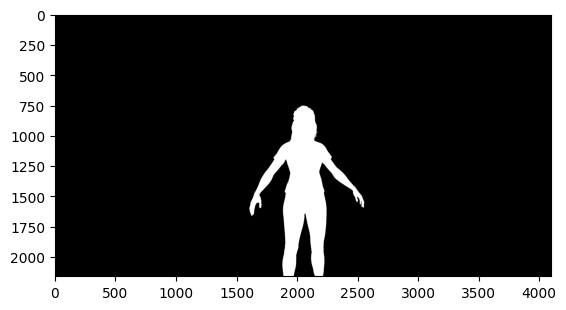

In [33]:
import matplotlib.pyplot as plt
binary_mask = binarize_mask(masks['Camera_1'], threshold=200)
plt.imshow(binary_mask, cmap='gray')

In [37]:
flow_msked = flow.copy() * binary_mask[:, :, np.newaxis]
flow_msked

array([[[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        ...,
        [ 0., -0.],
        [ 0., -0.],
        [ 0., -0.]],

       [[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        ...,
        [ 0., -0.],
        [ 0., -0.],
        [ 0., -0.]],

       [[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        ...,
        [ 0., -0.],
        [ 0., -0.],
        [ 0., -0.]],

       ...,

       [[ 0., -0.],
        [ 0., -0.],
        [ 0., -0.],
        ...,
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]],

       [[ 0., -0.],
        [ 0., -0.],
        [ 0., -0.],
        ...,
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]],

       [[ 0., -0.],
        [ 0., -0.],
        [ 0., -0.],
        ...,
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]]], dtype=float32)

In [38]:
# Obtain correspondance points
def get_new_locations(first_frame, flow, mask=None):
    """
    Get the new locations of the first frame pixels in the second frame using the optical flow map.
    
    Args:
        first_frame: The first image frame (HxW or HxWxC).
        flow: The optical flow map (HxWx2).
    
    Returns:
        new_locations: The new locations of the first frame pixels in the second frame (HxWx2).
    """
    height, width = first_frame.shape[:2]
    
    # Create a grid of coordinates in the first frame
    y, x = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
    
    # Extract the flow vectors
    u = flow[:, :, 0]
    v = flow[:, :, 1]
    
    # Compute the new locations
    new_x = x + u
    new_y = y + v

    if mask is not None:
        new_x = new_x[mask > 0]
        new_y = new_y[mask > 0]
        x = x[mask > 0]
        y = y[mask > 0]

    print(x.shape, y.shape)
    
    # Stack the new coordinates
    original_locations = np.stack((x, y), axis=-1)
    new_locations = np.stack((new_x, new_y), axis=-1)
    
    return original_locations, new_locations

In [39]:
points1, points2 = get_new_locations(img_ori, flow, binary_mask)

(739744,) (739744,)


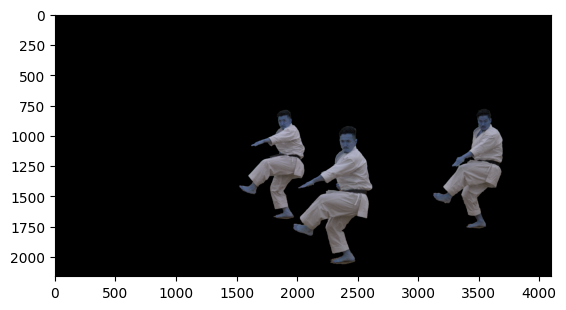

In [57]:
plt.imshow(img_ori)

In [86]:
print(M)

[[ 9.96842682e-01 -2.10817084e-02  7.65528455e-02 -1.20123604e+00]
 [ 7.93866962e-02  2.45296061e-01 -9.66192305e-01 -7.25688320e+00]
 [ 1.59087230e-03  9.69218969e-01  2.46195182e-01  3.80579266e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [78]:
img_w, img_h = cams['Camera_1'].cam_data['Filmback']['SensorResolutionWidth (pixels)'], cams['Camera_1'].cam_data['Filmback']['SensorResolutionHeight (pixels)']
M, _, _ = get_camera_poses(cams['Camera_1'].cam_data)
cx, cy = img_w / 2, img_h / 2
f, _ = cams['Camera_1'].focal_length_pixel(img_w, img_h)

# Projection matrix P (3x4)
K = np.array([[f, 0, cx, 0],
              [0, f, cy, 0],
              [0, 0,  1, 0]])   

P0 = K @ M

img_w, img_h = cams['Camera_3'].cam_data['Filmback']['SensorResolutionWidth (pixels)'], cams['Camera_3'].cam_data['Filmback']['SensorResolutionHeight (pixels)']
M, _, _ = get_camera_poses(cams['Camera_3'].cam_data)
cx, cy = img_w / 2, img_h / 2
f, _ = cams['Camera_3'].focal_length_pixel(img_w, img_h)

# Projection matrix P (3x4)
K = np.array([[f, 0, cx, 0],
              [0, f, cy, 0],
              [0, 0,  1, 0]])   

P1 = K @ M

KeyError: 'Camera_1'

In [79]:
def triangulate_point(P1, P2, point1, point2):
    """
    Triangulate a 3D point from two views.
    
    Args:
        P1: Projection matrix for the first camera (3x4).
        P2: Projection matrix for the second camera (3x4).
        point1: Homogeneous coordinates of the point in the first image (3x1).
        point2: Homogeneous coordinates of the point in the second image (3x1).
    
    Returns:
        X: Triangulated 3D point in homogeneous coordinates (4x1).
    """
    A = np.zeros((4, 4))
    A[0] = point1[0] * P1[2] - P1[0]
    A[1] = point1[1] * P1[2] - P1[1]
    A[2] = point2[0] * P2[2] - P2[0]
    A[3] = point2[1] * P2[2] - P2[1]
    
    _, _, V = np.linalg.svd(A)
    X = V[-1]
    X = X / X[3]
    return X

In [80]:
points1_h = np.concatenate((points1, np.ones((points1.shape[0], 1))), axis=1)
points2_h = np.concatenate((points2, np.ones((points2.shape[0], 1))), axis=1)
points1_h[:,1] = img_h - points1_h[:,1]
points2_h[:,1] = img_h - points2_h[:,1]
points2_h

array([[ 3.52926772e+03,  1.16966492e+03,  1.00000000e+00],
       [ 3.53015417e+03,  1.16917757e+03,  1.00000000e+00],
       [ 3.53102847e+03,  1.16882091e+03,  1.00000000e+00],
       ...,
       [ 2.60217577e+03, -8.43675537e+01,  1.00000000e+00],
       [ 2.60140721e+03, -8.31587219e+01,  1.00000000e+00],
       [ 2.60063867e+03, -8.19498749e+01,  1.00000000e+00]])

In [87]:
Xs = []
for i in range(0, points1_h.shape[0]):
    X = triangulate_point(P0, P1, points1_h[i], points2_h[i])
    Xs.append(X)

In [88]:
Xs = np.array(Xs)

In [89]:
img_ori = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)
colors = img_ori.copy()[binary_mask > 0]
colors.shape

(739744, 3)

In [91]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Xs[:,:3])
#pcd.colors = o3d.utility.Vector3dVector(colors/255.0)
#o3d.io.write_point_cloud(f"Camera_1_flo.ply", pcd)
#print(pcd)
o3d.visualization.draw_geometries([pcd])

### 2.2 Read camera parameters and create transformation matrix--parallel data

In [172]:
camerafile = "../../data/stereo/pose_z_4m/CameraData.json"
outputdir = basedir + "output/flow/parallel/"
files = glob.glob(outputdir + '*.flo')
cams = []
for file in files:
    fname = os.path.basename(file)
    cam_id = int(fname.split('_')[1])
    camera_data = Camera_info(camerafile, cam_id)
    cams.append(camera_data)

In [188]:
img_w, img_h = cams[0].cam_data['Filmback']['SensorResolutionWidth (pixels)'], cams[0].cam_data['Filmback']['SensorResolutionHeight (pixels)']
M, _, _ = get_camera_poses(cams[0].cam_data)
cx, cy = img_w / 2, img_h / 2
f, _ = cams[0].focal_length_pixel(img_w, img_h)

# Projection matrix P (3x4)
K = np.array([[f, 0, cx, 0],
              [0, f, cy, 0],
              [0, 0,  1, 0]])   
print(M)
print(K)
print(cams[0].cam_data)


[[-1.00000000e+00  0.00000000e+00 -1.22464680e-16  9.33333302e+01]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -4.00000000e+01]
 [ 1.22464680e-16  0.00000000e+00 -1.00000000e+00  4.00000000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[5.65656633e+03 0.00000000e+00 1.92000000e+03 0.00000000e+00]
 [0.00000000e+00 5.65656633e+03 1.08000000e+03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
{'Camera World Position': {'X': 400, 'Y': 93.33333015441895, 'Z': 40}, 'Camera World Rotation': {'P': 0, 'Y': 180, 'R': 0}, 'Filmback': {'SensorWidth (mm)': 23.760000228881836, 'SensorHeight (mm)': 13.364999771118164, 'SensorResolutionWidth (pixels)': 3840, 'SensorResolutionHeight (pixels)': 2160, 'SensorAspectRatio': 1.7777777910232544}, 'Lens': {'MinFocalLength (mm)': 4, 'MaxFocalLength (mm)': 1000, 'Horizontal Field of View (degrees)': 37.49735641479492}, 'Other': {'Near Clip Plane (cm)': 0.10000000149011612, 'Far Clip Plane (cm)': 

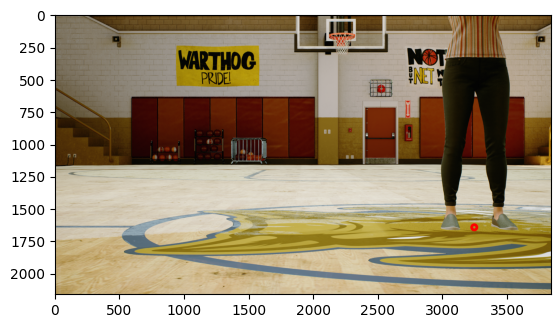

In [189]:
# To project a world point (x_i, y_i, z_i) to image coordinates:
P = K @ M
world_point = np.array([0, 0, 0, 1])  # Example world coordinates of the object
camera_point = P @ world_point
camera_point /= camera_point[2]  # Normalize by the third component

# Image coordinates (pixel)
u = camera_point[0]
v = img_h - camera_point[1]
u,v
center_coordinates = (int(u), int(v))
radius = 20
color = (255, 0, 0) # Blue color in BGR
thickness = 20 # Line thickness

# Draw the circle on the image
imgfile = 'demo/input/flow/parallel/Camera_000_RGB.png'
img = cv2.cvtColor(cv2.imread(imgfile), cv2.COLOR_BGR2RGB)
plt.imshow(cv2.circle(img.copy(), center_coordinates, radius, color, thickness))

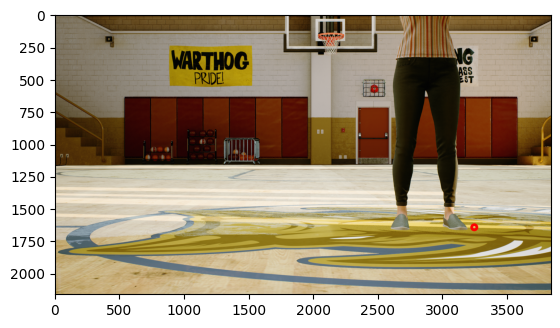

In [182]:
imgfile = 'demo/input/flow/parallel/Camera_001_RGB.png'
img = cv2.cvtColor(cv2.imread(imgfile), cv2.COLOR_BGR2RGB)
plt.imshow(cv2.circle(img.copy(), center_coordinates, radius, color, thickness))

In [190]:
img_w, img_h = cams[1].cam_data['Filmback']['SensorResolutionWidth (pixels)'], cams[0].cam_data['Filmback']['SensorResolutionHeight (pixels)']
M, _, _ = get_camera_poses(cams[1].cam_data)
cx, cy = img_w / 2, img_h / 2
f, _ = cams[1].focal_length_pixel(img_w, img_h)

# Projection matrix P (3x4)
K = np.array([[f, 0, cx, 0],
              [0, f, cy, 0],
              [0, 0,  1, 0]])   
print(M)
print(K)

[[-1.00000000e+00  0.00000000e+00 -1.22464680e-16  6.66666641e+01]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -4.00000000e+01]
 [ 1.22464680e-16  0.00000000e+00 -1.00000000e+00  4.00000000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[5.65656633e+03 0.00000000e+00 1.92000000e+03 0.00000000e+00]
 [0.00000000e+00 5.65656633e+03 1.08000000e+03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]


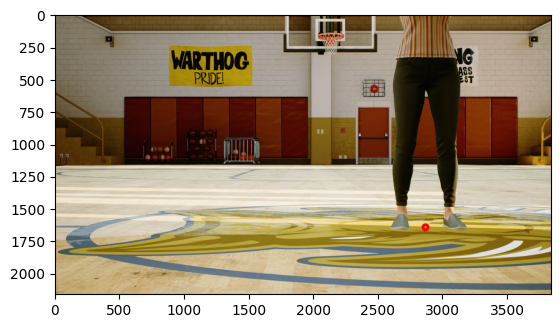

In [191]:
# To project a world point (x_i, y_i, z_i) to image coordinates:
P = K @ M
world_point = np.array([0, 0, 0, 1])  # Example world coordinates of the object
camera_point = P @ world_point
camera_point /= camera_point[2]  # Normalize by the third component

# Image coordinates (pixel)
u1 = camera_point[0]
v1 = img_h - camera_point[1]
u1,v1
center_coordinates = (int(u1), int(v1))
radius = 20
color = (255, 0, 0) # Blue color in BGR
thickness = 20 # Line thickness

# Draw the circle on the image
imgfile = 'demo/input/flow/parallel/Camera_001_RGB.png'
img = cv2.cvtColor(cv2.imread(imgfile), cv2.COLOR_BGR2RGB)
plt.imshow(cv2.circle(img.copy(), center_coordinates, radius, color, thickness))

In [193]:
print(u, v)
print(u1, v1)
print(u1-u, v1-v)
flow[int(v), int(u)]

3239.8654315856215 1645.6566328028446
2862.761018707928 1645.6566328028446
-377.10441287769345 0.0


array([-3.7771109e+02, -5.3042397e-03], dtype=float32)

### 2.3 Use triangulation to estimate the 3D position of corresponding points in the two images

In [195]:
def triangulate_point(P1, P2, point1, point2):
    """
    Triangulate a 3D point from two views.
    
    Args:
        P1: Projection matrix for the first camera (3x4).
        P2: Projection matrix for the second camera (3x4).
        point1: Homogeneous coordinates of the point in the first image (3x1).
        point2: Homogeneous coordinates of the point in the second image (3x1).
    
    Returns:
        X: Triangulated 3D point in homogeneous coordinates (4x1).
    """
    A = np.zeros((4, 4))
    A[0] = point1[0] * P1[2] - P1[0]
    A[1] = point1[1] * P1[2] - P1[1]
    A[2] = point2[0] * P2[2] - P2[0]
    A[3] = point2[1] * P2[2] - P2[1]
    
    _, _, V = np.linalg.svd(A)
    X = V[-1]
    X = X / X[3]
    return X

In [200]:
img_w, img_h = cams[0].cam_data['Filmback']['SensorResolutionWidth (pixels)'], cams[0].cam_data['Filmback']['SensorResolutionHeight (pixels)']
M, _, _ = get_camera_poses(cams[0].cam_data)
cx, cy = img_w / 2, img_h / 2
f, _ = cams[0].focal_length_pixel(img_w, img_h)

# Projection matrix P (3x4)
K = np.array([[f, 0, cx, 0],
              [0, f, cy, 0],
              [0, 0,  1, 0]])   

P0 = K @ M

img_w, img_h = cams[1].cam_data['Filmback']['SensorResolutionWidth (pixels)'], cams[1].cam_data['Filmback']['SensorResolutionHeight (pixels)']
M, _, _ = get_camera_poses(cams[1].cam_data)
cx, cy = img_w / 2, img_h / 2
f, _ = cams[1].focal_length_pixel(img_w, img_h)

# Projection matrix P (3x4)
K = np.array([[f, 0, cx, 0],
              [0, f, cy, 0],
              [0, 0,  1, 0]])   

P1 = K @ M

point0 = np.array([u, img_h-v, 1])
point1 = np.array([u1, img_h-v1, 1])

X = triangulate_point(P0, P1, point0, point1)
X


array([0.00000000e+00, 5.14514084e-15, 1.57772181e-30, 1.00000000e+00])

### 2.4 On 

In [132]:
#read camera intrinsics and poses from txt file
import matplotlib.pyplot as plt

def read_intrinsics(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    K = np.array([[float(x) for x in line.strip().split()] for line in lines], dtype=np.float32)
    return K

def read_poses(cam_dir):
    files = sorted(glob.glob(cam_dir + '/*.txt'))
    poses = {}
    for file in files:
        with open(file, 'r') as f:
            lines = f.readlines()
        basename = os.path.basename(file).split('.')[0]
        poses[basename] = np.array([[float(x) for x in line.strip().split()] for line in lines], dtype=np.float32)
    return poses


intrinsics = read_intrinsics('demo/input/depth/desk/intrinsic/intrinsic_depth.txt')
poses = read_poses('demo/input/depth/desk/pose/')
print(intrinsics)
print(poses)

[[577.5907    0.      318.90543   0.     ]
 [  0.      578.7298  242.68361   0.     ]
 [  0.        0.        1.        0.     ]
 [  0.        0.        0.        1.     ]]
{'0048': array([[ 0.703694, -0.367391,  0.608144,  1.89629 ],
       [-0.708482, -0.427345,  0.56163 ,  2.467417],
       [ 0.053549, -0.826075, -0.56101 ,  1.399475],
       [ 0.      ,  0.      ,  0.      ,  1.      ]], dtype=float32), '0066': array([[ 0.79458 , -0.2759  ,  0.540852,  1.915812],
       [-0.604505, -0.442681,  0.662273,  2.192295],
       [ 0.056703, -0.853178, -0.518529,  1.423975],
       [ 0.      ,  0.      ,  0.      ,  1.      ]], dtype=float32)}


In [32]:
# load flow map
import cv2
flow_rpg = cv2.imread('demo/output/flow/desk/0048_flow.png', cv2.IMREAD_UNCHANGED)

def read_flo_file(filename):
    with open(filename, 'rb') as f:
        # Read the header
        magic = np.fromfile(f, np.float32, count=1)[0]
        if magic != 202021.25:
            raise ValueError('Magic number incorrect. Invalid .flo file')
        
        # Read the width and height
        width = np.fromfile(f, np.int32, count=1)[0]
        height = np.fromfile(f, np.int32, count=1)[0]
        
        # Read the flow data
        data = np.fromfile(f, np.float32, count=2*width*height)
        flow = np.resize(data, (height, width, 2))
        
    return flow

# Example usage
flow = read_flo_file('demo/output/flow/desk/0048_pred.flo')
print(flow)


[[[ 74.29633   11.186624]
  [ 74.04855   11.051182]
  [ 74.31751   11.087069]
  ...
  [ 30.855803  36.585648]
  [ 30.799137  36.647346]
  [ 30.52972   36.773422]]

 [[ 74.12053   11.137116]
  [ 74.16442   11.1029  ]
  [ 74.42836   11.14496 ]
  ...
  [ 30.836687  36.671066]
  [ 30.682066  36.76217 ]
  [ 30.666828  36.762703]]

 [[ 73.9962    11.089501]
  [ 74.22216   11.133427]
  [ 74.4092    11.142563]
  ...
  [ 30.903603  36.72506 ]
  [ 30.655146  36.840363]
  [ 30.637932  36.819386]]

 ...

 [[ 26.419247 -57.824257]
  [ 26.168522 -57.781548]
  [ 25.989496 -57.768524]
  ...
  [-99.41682  -30.616882]
  [-99.468056 -30.711855]
  [-99.542595 -30.831194]]

 [[ 26.421665 -58.243828]
  [ 26.122192 -58.12362 ]
  [ 25.919548 -58.175983]
  ...
  [-99.52025  -30.915998]
  [-99.57244  -30.983622]
  [-99.68197  -31.136082]]

 [[ 26.37175  -58.725258]
  [ 26.086773 -58.552856]
  [ 25.83887  -58.605263]
  ...
  [-99.57537  -31.20131 ]
  [-99.65995  -31.303299]
  [-99.70769  -31.291279]]]


In [41]:
# Obtain correspondance points
def get_new_locations(first_frame, flow):
    """
    Get the new locations of the first frame pixels in the second frame using the optical flow map.
    
    Args:
        first_frame: The first image frame (HxW or HxWxC).
        flow: The optical flow map (HxWx2).
    
    Returns:
        new_locations: The new locations of the first frame pixels in the second frame (HxWx2).
    """
    height, width = first_frame.shape[:2]
    
    # Create a grid of coordinates in the first frame
    y, x = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')
    
    # Extract the flow vectors
    u = flow[:, :, 0]
    v = flow[:, :, 1]
    
    # Compute the new locations
    new_x = x + u
    new_y = y + v
    
    # Stack the new coordinates
    original_locations = np.stack((x, y), axis=-1)
    new_locations = np.stack((new_x, new_y), axis=-1)
    
    return original_locations, new_locations

points1, points2 = get_new_locations(flow_rpg, flow)
print(points1[0,0,:])
print(points2[0,0,:])
print(points1.shape)

[0 0]
[74.29633331 11.18662357]
(480, 640, 2)


In [42]:
def triangulate_points(P1, P2, points1, points2):
    """
    Triangulate 3D points from two views.
    
    Args:
        P1: Projection matrix for the first camera (3x4).
        P2: Projection matrix for the second camera (3x4).
        points1: Homogeneous coordinates of the points in the first image (Nx3).
        points2: Homogeneous coordinates of the points in the second image (Nx3).
    
    Returns:
        X: Triangulated 3D points in homogeneous coordinates (Nx4).
    """
    num_points = points1.shape[0]
    A = np.zeros((num_points * 4, 4))
    
    for i in range(num_points):
        A[4*i] = points1[i, 0] * P1[2] - P1[0]
        A[4*i + 1] = points1[i, 1] * P1[2] - P1[1]
        A[4*i + 2] = points2[i, 0] * P2[2] - P2[0]
        A[4*i + 3] = points2[i, 1] * P2[2] - P2[1]
    
    _, _, V = np.linalg.svd(A)
    X = V[-1].reshape(-1, 4)
    X = X / X[:, 3][:, np.newaxis]
    return X

In [ ]:
def triangulate_point(P1, P2, point1, point2):
    """
    Triangulate a 3D point from two views.
    
    Args:
        P1: Projection matrix for the first camera (3x4).
        P2: Projection matrix for the second camera (3x4).
        point1: Homogeneous coordinates of the point in the first image (3x1).
        point2: Homogeneous coordinates of the point in the second image (3x1).
    
    Returns:
        X: Triangulated 3D point in homogeneous coordinates (4x1).
    """
    A = np.zeros((4, 4))
    A[0] = point1[0] * P1[2] - P1[0]
    A[1] = point1[1] * P1[2] - P1[1]
    A[2] = point2[0] * P2[2] - P2[0]
    A[3] = point2[1] * P2[2] - P2[1]
    
    _, _, V = np.linalg.svd(A)
    X = V[-1]
    X = X / X[3]
    return X

In [43]:
# Create a list of homogeneous points from points1 and points2
points1 = points1.reshape(-1, 2)
points2 = points2.reshape(-1, 2)
points1_h = np.concatenate((points1, np.ones((points1.shape[0], 1))), axis=1)
points2_h = np.concatenate((points2, np.ones((points2.shape[0], 1))), axis=1)

In [48]:
P1 = intrinsics[:3,:3] @ poses['0048'][:-1,:]
P1

array([[ 4.2352417e+02, -4.7564142e+02,  1.7234917e+02,  1.5415796e+03],
       [-3.9702420e+02, -4.4779214e+02,  1.8888408e+02,  1.7675974e+03],
       [ 5.3548999e-02, -8.2607502e-01, -5.6101000e-01,  1.3994750e+00]],
      dtype=float32)

In [51]:
P2 = intrinsics[:3,:3] @ poses['0066'][:-1,:]
P2

array([[ 4.7702490e+02, -4.3144040e+02,  1.4702937e+02,  1.5606686e+03],
       [-3.3608417e+02, -4.6324500e+02,  2.5743860e+02,  1.6143219e+03],
       [ 5.6703001e-02, -8.5317802e-01, -5.1852900e-01,  1.4239750e+00]],
      dtype=float32)

In [73]:
depth_map = np.zeros((flow.shape[0] * flow.shape[1], 1))
Xs = []
for i in range(0, points1_h.shape[0]):
    X = triangulate_point(P1, P2, points1_h[i], points2_h[i])
    depth_map[i] = X[2]
    Xs.append(X)
depth_map = depth_map.reshape(flow.shape[0], flow.shape[1])

In [80]:
Xs = np.array(Xs)
Xs[:,:3].shape

(307200, 3)

In [82]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Xs[:,:3])
"""o3d.io.write_point_cloud(f"Camera_020.ply", pcd)
print(pcd)"""
o3d.visualization.draw_geometries([pcd])


In [76]:
Xs

[array([0.27981528, 6.08293618, 5.22870555, 1.        ]),
 array([0.27450565, 6.12021115, 5.29711317, 1.        ]),
 array([0.26604688, 6.14110609, 5.32529886, 1.        ]),
 array([0.25934535, 6.17180518, 5.37733383, 1.        ]),
 array([0.25641462, 6.22804161, 5.49021877, 1.        ]),
 array([0.24871004, 6.24802063, 5.51787376, 1.        ]),
 array([0.24163303, 6.27746082, 5.56665828, 1.        ]),
 array([0.23430911, 6.30488695, 5.61075158, 1.        ]),
 array([0.2332805 , 6.48030455, 5.97904551, 1.        ]),
 array([0.22513235, 6.51044529, 6.02739512, 1.        ]),
 array([0.21659378, 6.53116662, 6.05513717, 1.        ]),
 array([0.20820414, 6.55822179, 6.09655024, 1.        ]),
 array([0.19705957, 6.4900048 , 5.93156535, 1.        ]),
 array([0.18845518, 6.51208462, 5.9620317 , 1.        ]),
 array([0.17978825, 6.53310005, 5.99014402, 1.        ]),
 array([0.17121427, 6.56693456, 6.04549959, 1.        ]),
 array([0.16467303, 6.54854854, 5.99489457, 1.        ]),
 array([0.1557